### Import required modules and defining any utility functions if we need them

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts, StratifiedKFold as skf, permutation_test_score as pts
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
import json
import lightgbm as lgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


__Set float_format preference option for display to show max 3 values after decimal__

__Improves Readability__

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

__Utility functions for creating a backup of dataframe and load from backup if required. In case something fails or doesn't go as expected, I can load my DFs from this backup and won't have to re-run the whole Notebook everytime.__

In [3]:
import os
from datetime import datetime as dt
backup_file = "../dataset/backup.feather"
train_file = "../dataset/train_df.feather"
test_file = "../dataset/test_df.feather"

def write_df_to_feather(df, test_df, backup_df=None, overwrite=True):
    backup_files = [train_file, test_file, backup_file]
    if overwrite:
        for f in [train_file, test_file, backup_file]:
            if os.path.exists(f):
                os.remove(f)
    else:
        for f in [train_file, test_file, backup_file]:
            if os.path.exists(f):
                new_f = str(dt.now()).join(os.path.splitext(f))
                os.rename(f, new_f)
                backup_files.append(new_f)
    df.to_pickle(train_file)
    test_df.to_pickle(test_file)
    if isinstance(backup_df, pd.DataFrame):
        backup_df.to_pickle(backup_file)
    return backup_files[3:]

def load_last_checkpoint(backup_files=None):
    if type(backup_files) != type({}):
        print(" backup files should be a dict"\
            "with keys: train, test, backup")
    
        return (
            pd.read_pickle(train_file) if os.path.exists(train_file) else None, 
            pd.read_pickle(test_file) if os.path.exists(test_file) else None,  
            pd.read_pickle(backup_file) if os.path.exists(backup_file) else None
        )
    else:
        return (
            pd.read_pickle(backup_files['train']) if os.path.exists(backup_files['train']) else None, 
            pd.read_pickle(backup_files['test']) if os.path.exists(backup_files['test']) else None,  
            pd.read_pickle(backup_files['backup']) if os.path.exists(backup_files['backup']) else None
        )
    
    

### Load CSVs

In [4]:
train_df = pd.read_csv('../dataset/train.csv', dtype={
                                                    'fullVisitorId': str, 
                                                    'visitId': str})
test_df = pd.read_csv('../dataset/test.csv', dtype={
                                                    'fullVisitorId': str, 
                                                    'visitId': str})

__JSON values will have to be expanded into columns for further processing__

In [5]:
def expand_json_to_columns(df, column):
    df[column] = df[column].apply(json.loads)
    json_df = json_normalize(df[column])
    json_df.columns = ["{}-{}".format(column, subcolumn) for subcolumn in json_df.columns]
    df.drop(column, axis=1, inplace=True)
    df = df.merge(json_df, right_index=True, left_index=True)
    
    print("New Shape of df: {}".format(str(df.shape)))
    return df

In [6]:
def convert_date_and_visitStartTime(df):
    df['date'] = pd.to_datetime(df.date, format="%Y%m%d")
    df['visitStartTime'] = pd.to_datetime(df.visitStartTime, unit='s')
    return df

In [7]:
train_df.columns

Index(['channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
       'sessionId', 'socialEngagementType', 'totals', 'trafficSource',
       'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [8]:
columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

for column in columns: 
    train_df = expand_json_to_columns(train_df, column)
    test_df = expand_json_to_columns(test_df, column)

New Shape of df: (903653, 27)
New Shape of df: (804684, 27)
New Shape of df: (903653, 37)
New Shape of df: (804684, 37)
New Shape of df: (903653, 42)
New Shape of df: (804684, 41)
New Shape of df: (903653, 55)
New Shape of df: (804684, 53)


In [9]:
train_df = convert_date_and_visitStartTime(train_df)
test_df = convert_date_and_visitStartTime(test_df)

In [10]:
columns = train_df.columns
display(columns); display(train_df.head()); display(train_df.describe(include='all'))

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device-browser', 'device-browserSize', 'device-browserVersion',
       'device-deviceCategory', 'device-flashVersion', 'device-isMobile',
       'device-language', 'device-mobileDeviceBranding',
       'device-mobileDeviceInfo', 'device-mobileDeviceMarketingName',
       'device-mobileDeviceModel', 'device-mobileInputSelector',
       'device-operatingSystem', 'device-operatingSystemVersion',
       'device-screenColors', 'device-screenResolution', 'geoNetwork-city',
       'geoNetwork-cityId', 'geoNetwork-continent', 'geoNetwork-country',
       'geoNetwork-latitude', 'geoNetwork-longitude', 'geoNetwork-metro',
       'geoNetwork-networkDomain', 'geoNetwork-networkLocation',
       'geoNetwork-region', 'geoNetwork-subContinent', 'totals-bounces',
       'totals-hits', 'totals-newVisits', 'totals-pageviews',
       'totals-transactionRevenue

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device-browser,device-browserSize,...,trafficSource-adwordsClickInfo.isVideoAd,trafficSource-adwordsClickInfo.page,trafficSource-adwordsClickInfo.slot,trafficSource-campaign,trafficSource-campaignCode,trafficSource-isTrueDirect,trafficSource-keyword,trafficSource-medium,trafficSource-referralPath,trafficSource-source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,2016-09-02 15:33:05,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,2016-09-03 05:22:27,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,2016-09-03 01:16:26,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,2016-09-03 05:40:13,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,2016-09-02 13:23:20,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device-browser,device-browserSize,...,trafficSource-adwordsClickInfo.isVideoAd,trafficSource-adwordsClickInfo.page,trafficSource-adwordsClickInfo.slot,trafficSource-campaign,trafficSource-campaignCode,trafficSource-isTrueDirect,trafficSource-keyword,trafficSource-medium,trafficSource-referralPath,trafficSource-source
count,903653,903653,903653,903653,903653,903653,903653.000,903653,903653,903653,...,21460,21460,21460,903653,1,274005,400724,903653,330941,903653
unique,8,366,714167,902755,1,886303,nan,887159,54,1,...,1,8,2,10,1,1,3659,7,1475,380
top,Organic Search,2016-11-28 00:00:00,1957458976293878100,0865626199868560806_1496904243,Not Socially Engaged,1493146175,nan,2017-04-25 18:49:35,Chrome,not available in demo dataset,...,False,1,Top,(not set),11251kjhkvahf,True,(not provided),organic,/,google
freq,381561,4807,278,2,903653,8,nan,8,620364,903653,...,21460,21362,20956,865347,1,274005,366363,381561,75523,400788
first,NaN,2016-08-01 00:00:00,NaN,NaN,NaN,NaN,nan,2016-08-01 07:00:12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2017-08-01 00:00:00,NaN,NaN,NaN,NaN,nan,2017-08-02 06:59:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.265,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,9.284,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
backup_files = write_df_to_feather(train_df, test_df)

### Let the cleaning begin

__Extract columns with only one unique value in them. We'll explore these further and drop them if nothing can be done since non-changing values won't contribute to the prediction.__

In [12]:
unique_value_columns = [col for col in train_df.columns if train_df[col].nunique()==1]
display(train_df[unique_value_columns].describe(include='all'))

,socialEngagementType,device-browserSize,device-browserVersion,device-flashVersion,device-language,device-mobileDeviceBranding,device-mobileDeviceInfo,device-mobileDeviceMarketingName,device-mobileDeviceModel,device-mobileInputSelector,...,geoNetwork-latitude,geoNetwork-longitude,geoNetwork-networkLocation,totals-bounces,totals-newVisits,totals-visits,trafficSource-adwordsClickInfo.criteriaParameters,trafficSource-adwordsClickInfo.isVideoAd,trafficSource-campaignCode,trafficSource-isTrueDirect
count,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,...,903653,903653,903653,450630,703060,903653,903653,21460,1,274005
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,not available in demo dataset,False,11251kjhkvahf,True
freq,903653,903653,903653,903653,903653,903653,903653,903653,903653,903653,...,903653,903653,903653,450630,703060,903653,903653,21460,1,274005


In [13]:
# Values that look of no use at first glance. Let's remove these and we'll explore the remaining futher. 
# Criteria for removal: unique value in the column i.e nunique == 1, count == 903653 i.e. no null values
drop_columns = [col for col in train_df.columns if (train_df[col].nunique()==1) and (train_df[col].count() == 903653)]
r_unique_value_columns = list(set(unique_value_columns).difference(set(drop_columns)))
print(f"Number of columns dropped: {len(drop_columns)}"); print(f"Number of columns kept: {len(r_unique_value_columns)}")

Number of columns dropped: 19
Number of columns kept: 5


In [14]:
#checkpoint
backup = train_df[drop_columns]
train_df.drop(drop_columns, axis=1, inplace=True)
test_df.drop(drop_columns, axis=1, inplace=True)
backup_files = write_df_to_feather(train_df, test_df, backup, overwrite=False)

In [15]:
backup_files

['../dataset/train_df2018-10-23 05:51:05.439274.feather',
 '../dataset/test_df2018-10-23 05:51:05.452300.feather']

In [16]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device-browser,device-deviceCategory,device-isMobile,...,trafficSource-adwordsClickInfo.isVideoAd,trafficSource-adwordsClickInfo.page,trafficSource-adwordsClickInfo.slot,trafficSource-campaign,trafficSource-campaignCode,trafficSource-isTrueDirect,trafficSource-keyword,trafficSource-medium,trafficSource-referralPath,trafficSource-source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,UC Browser,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,True,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


__Taking a closer look at the columns we decided to keep__

In [17]:
r_unique_values = train_df[r_unique_value_columns]
r_unique_values.describe(include='all')

,totals-bounces,trafficSource-adwordsClickInfo.isVideoAd,trafficSource-isTrueDirect,totals-newVisits,trafficSource-campaignCode
count,450630,21460,274005,703060,1
unique,1,1,1,1,1
top,1,False,True,1,11251kjhkvahf
freq,450630,21460,274005,703060,1


* __There is only one value in trafficSource-campaignCode. This might or might not be playing a significant role in whether this user ends up generating any revenue. We can look at this later, let's remove the column for now__
* __The count returned for all the columns is less than the total count of the df. This implies that the remaining values in the columns are NaN.__
* __The total number of values in totals-newVisits, it looks like is equal to the number of unique visitor ids in the dataset. Looks like it's just marking the first visits of the users based on thier IDs. If that's the case, we can fill up the rest of the column with a false value and in our case 0.__
* __Rest of them as of now do not seem as straight forward so putting them in the ignore list. We can bring them in at a later point in time to see if we can figure out exactly what they mean and if there's a way to get the missing values to improve our predictions__

In [18]:
ignore_columns = [
    'trafficSource-campaignCode', 
    'totals-bounces', 
    'trafficSource-isTrueDirect', 
    'trafficSource-adwordsClickInfo.isVideoAd'
]
feature_list = list(train_df.columns)
for ignore_column in ignore_columns:
    feature_list.remove(ignore_column)

display(feature_list)

['channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device-browser',
 'device-deviceCategory',
 'device-isMobile',
 'device-operatingSystem',
 'geoNetwork-city',
 'geoNetwork-continent',
 'geoNetwork-country',
 'geoNetwork-metro',
 'geoNetwork-networkDomain',
 'geoNetwork-region',
 'geoNetwork-subContinent',
 'totals-hits',
 'totals-newVisits',
 'totals-pageviews',
 'totals-transactionRevenue',
 'trafficSource-adContent',
 'trafficSource-adwordsClickInfo.adNetworkType',
 'trafficSource-adwordsClickInfo.gclId',
 'trafficSource-adwordsClickInfo.page',
 'trafficSource-adwordsClickInfo.slot',
 'trafficSource-campaign',
 'trafficSource-keyword',
 'trafficSource-medium',
 'trafficSource-referralPath',
 'trafficSource-source']

Not dropping the column but removing the value from a list of features that we wish to consider for our final predictions. This allows an easy re-inclusion of the vlaue in case we need to include it again.

_populating totals-newVisits_

In [19]:
def populateNewVisits(df):
    col = 'totals-newVisits'
    null_indexes = df.loc[:, col].isna()
    df.loc[null_indexes, col] = 0
    df.loc[:, col] = df[col].astype(int)
    return df

train_df = populateNewVisits(train_df); test_df = populateNewVisits(test_df)

display(train_df['totals-newVisits'].describe()); display(test_df['totals-newVisits'].describe())

count   903653.000
mean         0.778
std          0.416
min          0.000
25%          1.000
50%          1.000
75%          1.000
max          1.000
Name: totals-newVisits, dtype: float64

count   804684.000
mean         0.751
std          0.432
min          0.000
25%          1.000
50%          1.000
75%          1.000
max          1.000
Name: totals-newVisits, dtype: float64

In [20]:
get_columns = lambda col_key: [column for column in train_df.columns if col_key in column]
totals_columns = get_columns('totals')
device_columns = get_columns('device')
traffic_columns = get_columns('trafficSource')
geoNetwork_columns = get_columns('geoNetwork')
display(totals_columns, device_columns, traffic_columns, geoNetwork_columns)

['totals-bounces',
 'totals-hits',
 'totals-newVisits',
 'totals-pageviews',
 'totals-transactionRevenue']

['device-browser',
 'device-deviceCategory',
 'device-isMobile',
 'device-operatingSystem']

['trafficSource-adContent',
 'trafficSource-adwordsClickInfo.adNetworkType',
 'trafficSource-adwordsClickInfo.gclId',
 'trafficSource-adwordsClickInfo.isVideoAd',
 'trafficSource-adwordsClickInfo.page',
 'trafficSource-adwordsClickInfo.slot',
 'trafficSource-campaign',
 'trafficSource-campaignCode',
 'trafficSource-isTrueDirect',
 'trafficSource-keyword',
 'trafficSource-medium',
 'trafficSource-referralPath',
 'trafficSource-source']

['geoNetwork-city',
 'geoNetwork-continent',
 'geoNetwork-country',
 'geoNetwork-metro',
 'geoNetwork-networkDomain',
 'geoNetwork-region',
 'geoNetwork-subContinent']

__Next set of problems that we can face in our prediction are columns which are not unique but have NaN values. Action required for these columns would be to explore them further and figure out if these can be replaced or the column needs to be dropped__

In [21]:
null_value_list = train_df[feature_list].columns[train_df[feature_list].isna().any()].tolist()

In [22]:
train_df[null_value_list].describe()

,totals-pageviews,totals-transactionRevenue,trafficSource-adContent,trafficSource-adwordsClickInfo.adNetworkType,trafficSource-adwordsClickInfo.gclId,trafficSource-adwordsClickInfo.page,trafficSource-adwordsClickInfo.slot,trafficSource-keyword,trafficSource-referralPath
count,903553,11515,10946,21460,21561,21460,21460,400724,330941
unique,213,5332,44,2,17774,8,2,3659,1475
top,1,16990000,Google Merchandise Collection,Google Search,Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3Zd...,1,Top,(not provided),/
freq,452522,256,5122,21453,70,21362,20956,366363,75523


* __totals-pageviews is missing a few values, looks like it won't be too difficult to replace these values. Let's keep this and look into it futher.__
* __totals-transactionRevenue seems to be containing nan values for all non-transactional visits. This can be replaced with zeros__
* __Rest of the columns either contain too few values to actually help in the prediction. Putting the columns in ignore list for the time being. We can come back to this later.__

In [23]:
ignore_columns.extend(null_value_list)
ignore_columns.remove('totals-pageviews')
ignore_columns.remove('totals-transactionRevenue')
feature_list = list(set(train_df.columns) - set(ignore_columns))

In [24]:
feature_list

['geoNetwork-networkDomain',
 'trafficSource-medium',
 'sessionId',
 'date',
 'totals-pageviews',
 'visitStartTime',
 'visitId',
 'device-browser',
 'totals-hits',
 'geoNetwork-metro',
 'trafficSource-source',
 'device-deviceCategory',
 'geoNetwork-region',
 'visitNumber',
 'geoNetwork-continent',
 'totals-newVisits',
 'geoNetwork-country',
 'device-isMobile',
 'geoNetwork-subContinent',
 'fullVisitorId',
 'totals-transactionRevenue',
 'trafficSource-campaign',
 'geoNetwork-city',
 'channelGrouping',
 'device-operatingSystem']

In [25]:
display(train_df.groupby('totals-pageviews').size().sort_values(ascending=False).iloc[:5])
display(test_df.groupby('totals-pageviews').size().sort_values(ascending=False).iloc[:5])

totals-pageviews
1    452522
2    143770
3     73835
4     45192
5     33411
dtype: int64

totals-pageviews
1    423806
2    106024
3     69061
4     41474
5     31301
dtype: int64

In [26]:
# Since the value 1 seems to be in majority, let's replace the missing values 
# in pageviews with 1. This could depend on other parameters, but we can come
# back to futher exploration of the feature once we consider the other columns
# from our ignore list.
def fillPageViews(df):
    col = 'totals-pageviews'
    null_indexes = df[df[col].isna()].index
    df.loc[null_indexes, col] = 1
    df[col] = df[col].astype(int)
    return df, null_indexes

train_df, ni_tr = fillPageViews(train_df)
test_df, ni_ts = fillPageViews(test_df)
null_indexes_for_page_views = [ni_tr, ni_ts]

# checkpoint
display(write_df_to_feather(train_df, test_df, overwrite=False))



['../dataset/train_df2018-10-23 05:52:42.294708.feather',
 '../dataset/test_df2018-10-23 05:52:42.295533.feather',
 '../dataset/backup2018-10-23 05:52:42.295704.feather']

In [27]:
train_df, test_df, backup = load_last_checkpoint()

 backup files should be a dictwith keys: train, test, backup


In [28]:
# Replacing all nan values in transactionRevenue with 0
train_df['totals-transactionRevenue'] = train_df['totals-transactionRevenue'].fillna(0)
train_df['totals-transactionRevenue'] = train_df['totals-transactionRevenue'].astype(float)

In [29]:
# changing totals-hits to an integer value
train_df['totals-hits'] = train_df['totals-hits'].astype(int)

In [30]:
pd.set_option('display.max_columns', 25)
train_df[feature_list].describe(include='all')

,geoNetwork-networkDomain,trafficSource-medium,sessionId,date,totals-pageviews,visitStartTime,visitId,device-browser,totals-hits,geoNetwork-metro,trafficSource-source,device-deviceCategory,geoNetwork-region,visitNumber,geoNetwork-continent,totals-newVisits,geoNetwork-country,device-isMobile,geoNetwork-subContinent,fullVisitorId,totals-transactionRevenue,trafficSource-campaign,geoNetwork-city,channelGrouping,device-operatingSystem
count,903653,903653,903653,903653,903653.000,903653,903653,903653,903653.000,903653,903653,903653,903653,903653.000,903653,903653.000,903653,903653,903653,903653,903653.000,903653,903653,903653,903653
unique,28064,7,902755,366,nan,887159,886303,54,nan,94,380,3,376,nan,6,nan,222,2,23,714167,nan,10,649,8,20
top,(not set),organic,0865626199868560806_1496904243,2016-11-28 00:00:00,nan,2017-04-25 18:49:35,1493146175,Chrome,nan,not available in demo dataset,google,desktop,not available in demo dataset,nan,Americas,nan,United States,False,Northern America,1957458976293878100,nan,(not set),not available in demo dataset,Organic Search,Windows
freq,244881,381561,2,4807,nan,8,8,620364,nan,508229,400788,664479,508229,nan,450377,nan,364744,664530,390657,278,nan,865347,508229,381561,350072
first,NaN,NaN,NaN,2016-08-01 00:00:00,nan,2016-08-01 07:00:12,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2017-08-01 00:00:00,nan,2017-08-02 06:59:53,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,3.849,NaN,NaN,NaN,4.597,NaN,NaN,NaN,NaN,2.265,NaN,0.778,NaN,NaN,NaN,NaN,1704272.813,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,7.025,NaN,NaN,NaN,9.641,NaN,NaN,NaN,NaN,9.284,NaN,0.416,NaN,NaN,NaN,NaN,52778659.305,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,1.000,NaN,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,1.000,NaN,1.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN


### Visualization 

device-browser
Chrome              1383104960000.000
Firefox               89316320000.000
Safari                52397480000.000
Internet Explorer      8255550000.000
Edge                   6482970000.000
Opera                   215350000.000
Safari (in-app)         153770000.000
Android Webview         114850000.000
Amazon Silk              29990000.000
DASH_JR_3G                      0.000
Name: totals-transactionRevenue, dtype: float64

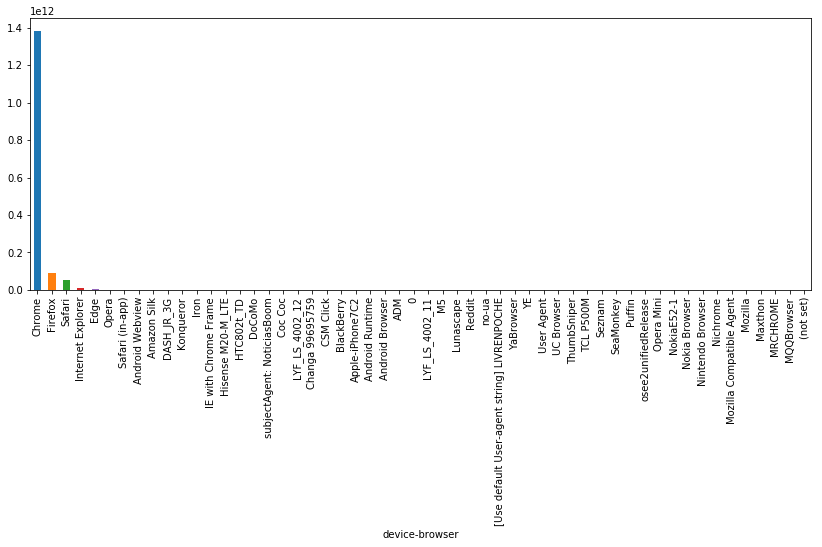

In [31]:
plt.figure(figsize=(14, 5))
browser_importance = train_df.groupby('device-browser')['totals-transactionRevenue'].sum().sort_values(ascending=False)
browser_importance.plot(kind='bar')
display(browser_importance[:10])

In [32]:
# Since major contribution is coming from the first 9 browswers, we should be able to safely
# remove the remaining browsers without affecting our predictions.
mrg_browsers = ['Chrome', 'Firefox', 'Safari', 'Internet Explorer', 'Edge', 'Opera', 'Safari (in-app)', 'Android Webview', 'Amazon Silk']
def eleminate_browsers(df):
    df['device-browser'] = df['device-browser'].apply(lambda x: x if x in mrg_browsers else 'Other')
    return df

train_df = eleminate_browsers(train_df)
test_df = eleminate_browsers(test_df)

device-operatingSystem
Macintosh       856375790000.000
Windows         397312720000.000
Chrome OS       183937750000.000
Linux            43910400000.000
Android          36341280000.000
iOS              22166900000.000
Windows Phone       26400000.000
NTT DoCoMo                 0.000
BlackBerry                 0.000
Firefox OS                 0.000
Name: totals-transactionRevenue, dtype: float64

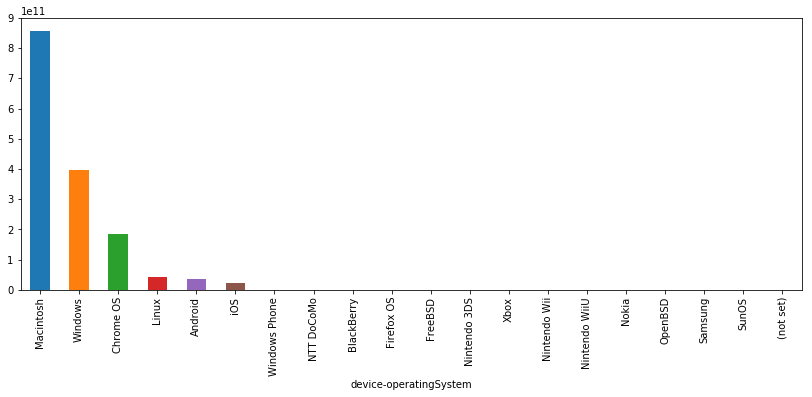

In [33]:
plt.figure(figsize=(14, 5))
browser_importance = train_df.groupby('device-operatingSystem')['totals-transactionRevenue'].sum().sort_values(ascending=False)
browser_importance.plot(kind='bar')
display(browser_importance[:10])

In [34]:
mrg_os = ['Macintosh', 'Windows', 'Chrome OS', 'Linux', 'Android', 'iOS', 'Windows Phone']
def eleminate_os(df):
    df['device-operatingSystem'] = df['device-operatingSystem'].apply(lambda x: x if x in mrg_os else 'Other')
    return df

train_df = eleminate_os(train_df)
test_df = eleminate_os(test_df)

In [35]:
train_df['device-operatingSystem'].unique()

array(['Windows', 'Macintosh', 'Linux', 'Android', 'iOS', 'Chrome OS',
       'Other', 'Windows Phone'], dtype=object)

In [36]:
rev_df = train_df.groupby('fullVisitorId')[['totals-transactionRevenue']].sum()

In [37]:
hits_df = train_df.groupby('fullVisitorId')[['totals-hits', 'totals-pageviews']].sum()
visits_df = train_df.groupby('fullVisitorId')[['visitNumber']].max()

In [38]:
rev_hits = rev_df.merge(hits_df, left_index=True, right_index=True)
rev_hits = rev_hits.merge(visits_df, left_index=True, right_index=True)

In [39]:
rev_hits['totals-transactionRevenue'] = rev_hits['totals-transactionRevenue'].apply(np.log1p)

In [40]:
rev_hits = rev_hits.sort_values(by='totals-hits')
rev_hits.head()

,totals-transactionRevenue,totals-hits,totals-pageviews,visitNumber
fullVisitorId,,,,
4286072280252638670,0.000,1,1,1
487971399137486680,0.000,1,1,2
487969750030394187,0.000,1,1,1
4879663349804254527,0.000,1,1,1
4879651038305837878,0.000,1,1,1


In [41]:
rev_hits.corr()

,totals-transactionRevenue,totals-hits,totals-pageviews,visitNumber
totals-transactionRevenue,1.000,0.414,0.419,0.172
totals-hits,0.414,1.000,0.991,0.565
totals-pageviews,0.419,0.991,1.000,0.591
visitNumber,0.172,0.565,0.591,1.000


In [78]:
heatmap_df = train_df.groupby(['channelGrouping', 'device-browser'])[['totals-transactionRevenue']].sum().apply(np.log1p).reset_index()
heatmap_df.head()

,channelGrouping,device-browser,totals-transactionRevenue
0,(Other),Chrome,16.117
1,(Other),Firefox,0.000
2,(Other),Internet Explorer,0.000
3,(Other),Other,0.000
4,(Other),Safari,0.000


In [79]:
heatmap_df = heatmap_df.pivot('device-browser', 'channelGrouping', 'totals-transactionRevenue').fillna(0)

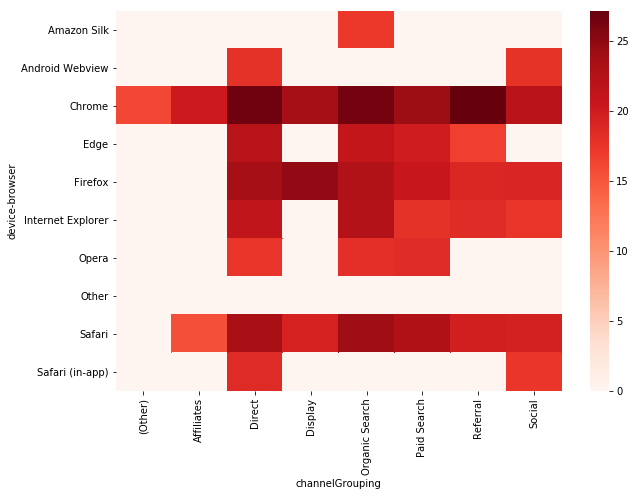

In [173]:
plt.figure(figsize=(10,7))
sns.heatmap(heatmap_df, cmap='Reds', )

In [65]:
revenue_hits = train_df.groupby('fullVisitorId')[['totals-transactionRevenue', 'totals-pageviews']].sum()

In [66]:
revenue_hits['totals-transactionRevenue'] = revenue_hits['totals-transactionRevenue'].apply(np.log1p)

In [67]:
revenue_hits = revenue_hits.sort_values(by='totals-pageviews', ascending=True)

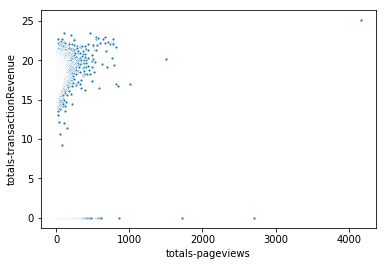

In [69]:
sns.scatterplot(x=revenue_hits['totals-pageviews'], y=revenue_hits['totals-transactionRevenue'], marker='.')

In [105]:
os_revenue = train_df.groupby('device-operatingSystem')[['totals-transactionRevenue']].sum().sort_values(by='totals-transactionRevenue', ascending=False)
os_revenue

,totals-transactionRevenue
device-deviceCategory,
desktop,1480864090000.000
mobile,49785810000.000
tablet,9421340000.000


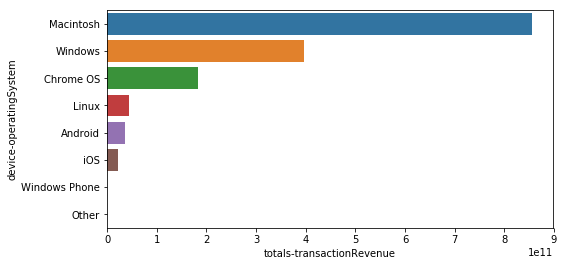

In [104]:
plt.figure(figsize=(8, 4))
sns.barplot(y=os_revenue.index, x=os_revenue['totals-transactionRevenue'])

Device distribution based on revenue generation: 

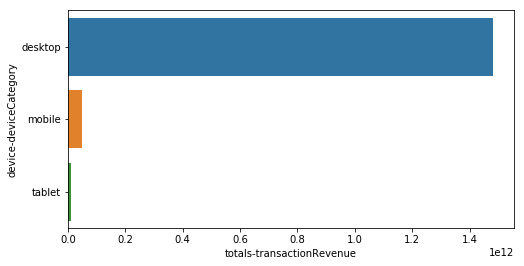

In [106]:
device_revenue = train_df.groupby('device-deviceCategory')[['totals-transactionRevenue']].sum().sort_values(by='totals-transactionRevenue', ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(y=device_revenue.index, x=device_revenue['totals-transactionRevenue'])

### 3 Clustering based on geographic data

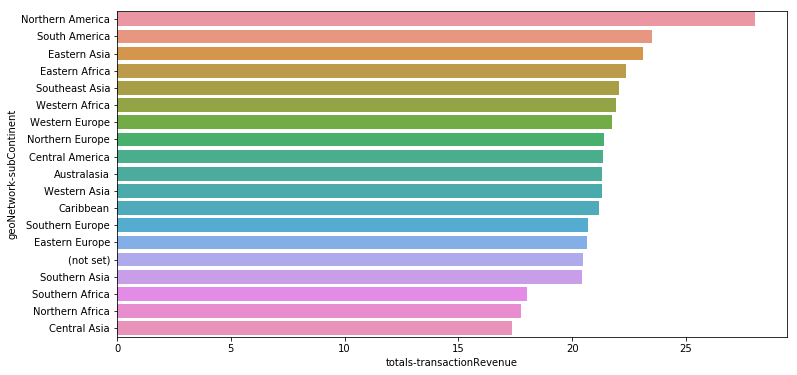

In [118]:
# Subcontinents generating maximum revenue vs max-clicks
subco_rev = train_df.groupby('geoNetwork-subContinent')[['totals-transactionRevenue']].sum().apply(np.log1p).sort_values(by='totals-transactionRevenue', ascending=False).iloc[:19]
plt.figure(figsize=(12, 6))
sns.barplot(y=subco_rev.index, x=subco_rev['totals-transactionRevenue'])

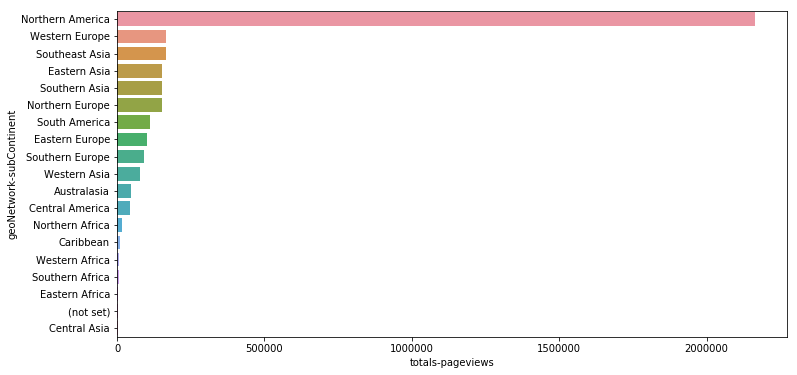

In [121]:
subco_rev = train_df.groupby('geoNetwork-subContinent')[['totals-pageviews']].sum().sort_values(by='totals-pageviews', ascending=False).iloc[:19]
plt.figure(figsize=(12, 6))
sns.barplot(y=subco_rev.index, x=subco_rev['totals-pageviews'])

### Question 4: Creating a ranking function

In [122]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device-browser,device-deviceCategory,device-isMobile,device-operatingSystem,geoNetwork-city,...,trafficSource-adwordsClickInfo.adNetworkType,trafficSource-adwordsClickInfo.gclId,trafficSource-adwordsClickInfo.isVideoAd,trafficSource-adwordsClickInfo.page,trafficSource-adwordsClickInfo.slot,trafficSource-campaign,trafficSource-campaignCode,trafficSource-isTrueDirect,trafficSource-keyword,trafficSource-medium,trafficSource-referralPath,trafficSource-source
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,Windows,Izmir,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,False,Macintosh,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,False,Windows,Madrid,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,Other,desktop,False,Linux,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,True,Android,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [123]:
prob_function_df = train_df.groupby('fullVisitorId')['totals-pageviews'].sum().sort_values()

In [124]:
total_page_views = prob_function_df.sum()
prob_page_visit = prob_function_df.apply(lambda x: x/total_page_views)

In [125]:
top_probability_users = prob_page_visit.sort_values(ascending=False).iloc[:10].index

In [126]:
top_probability_users

Index(['1957458976293878100', '0824839726118485274', '1856749147915772585',
       '9894955795481014038', '7634897085866546110', '4913801338365738862',
       '5208937953046059083', '0232377434237234751', '2194592743396253647',
       '7813149961404844386'],
      dtype='object', name='fullVisitorId')

In [177]:
top_10 = train_df.groupby('fullVisitorId')['totals-transactionRevenue'].sum().sort_values(ascending=False)[:10].index

In [178]:
count = 0
for i in top_10:
    if i in top_probability_users:
        count += 1

print(count)

1


### Question 5: Loading external GDP dataset

In [127]:
ext_df1 = pd.read_csv('../dataset/Country.csv')
ext_df2 = pd.read_csv('../dataset/InternetUsersDataset.csv')

In [128]:
ext_df1.shape, display(ext_df1.head()), display(ext_df1.columns)
ext_df2.shape, display(ext_df2.head()), display(ext_df2.columns)

,CountryCode,ShortName,TableName,LongName,Alpha2Code,CurrencyUnit,SpecialNotes,Region,IncomeGroup,Wb2Code,NationalAccountsBaseYear,NationalAccountsReferenceYear,...,ExternalDebtReportingStatus,SystemOfTrade,GovernmentAccountingConcept,ImfDataDisseminationStandard,LatestPopulationCensus,LatestHouseholdSurvey,SourceOfMostRecentIncomeAndExpenditureData,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData
0,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,2002/03,NaN,...,Actual,General trade system,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,nan,2013.000,2000.000
1,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,Original chained constant price data are resca...,1996,...,Actual,General trade system,Budgetary central government,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2011.000,2013.000,2006.000
2,DZA,Algeria,Algeria,People's Democratic Republic of Algeria,DZ,Algerian dinar,NaN,Middle East & North Africa,Upper middle income,DZ,1980,NaN,...,Actual,Special trade system,Budgetary central government,General Data Dissemination System (GDDS),2008,"Multiple Indicator Cluster Survey (MICS), 2012","Integrated household survey (IHS), 1995",NaN,NaN,2010.000,2013.000,2001.000
3,ASM,American Samoa,American Samoa,American Samoa,AS,U.S. dollar,NaN,East Asia & Pacific,Upper middle income,AS,NaN,NaN,...,NaN,Special trade system,NaN,NaN,2010,NaN,NaN,Yes,2007,nan,nan,nan
4,ADO,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,2000,NaN,...,NaN,Special trade system,NaN,NaN,2011. Population data compiled from administra...,NaN,NaN,Yes,NaN,nan,2006.000,nan


Index(['CountryCode', 'ShortName', 'TableName', 'LongName', 'Alpha2Code',
       'CurrencyUnit', 'SpecialNotes', 'Region', 'IncomeGroup', 'Wb2Code',
       'NationalAccountsBaseYear', 'NationalAccountsReferenceYear',
       'SnaPriceValuation', 'LendingCategory', 'OtherGroups',
       'SystemOfNationalAccounts', 'AlternativeConversionFactor',
       'PppSurveyYear', 'BalanceOfPaymentsManualInUse',
       'ExternalDebtReportingStatus', 'SystemOfTrade',
       'GovernmentAccountingConcept', 'ImfDataDisseminationStandard',
       'LatestPopulationCensus', 'LatestHouseholdSurvey',
       'SourceOfMostRecentIncomeAndExpenditureData',
       'VitalRegistrationComplete', 'LatestAgriculturalCensus',
       'LatestIndustrialData', 'LatestTradeData', 'LatestWaterWithdrawalData'],
      dtype='object')

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Unnamed: 61
0,Aruba,ABW,Internet users (per 100 people),IT.NET.USER.P2,nan,nan,nan,nan,nan,nan,nan,nan,...,28.000,30.900,52.000,58.000,62.000,69.000,74.000,78.900,83.780,88.661,nan,nan
1,Andorra,AND,Internet users (per 100 people),IT.NET.USER.P2,nan,nan,nan,nan,nan,nan,nan,nan,...,48.937,70.870,70.040,78.530,81.000,81.000,86.434,94.000,95.900,96.910,nan,nan
2,Afghanistan,AFG,Internet users (per 100 people),IT.NET.USER.P2,nan,nan,nan,nan,nan,nan,nan,nan,...,2.107,1.900,1.840,3.550,4.000,5.000,5.455,5.900,7.000,8.260,nan,nan
3,Angola,AGO,Internet users (per 100 people),IT.NET.USER.P2,nan,nan,nan,nan,nan,nan,nan,nan,...,1.500,1.700,1.900,2.300,2.800,3.100,6.500,8.900,10.200,12.400,nan,nan
4,Albania,ALB,Internet users (per 100 people),IT.NET.USER.P2,nan,nan,nan,nan,nan,nan,nan,nan,...,9.610,15.036,23.860,41.200,45.000,49.000,54.656,57.200,60.100,63.253,nan,nan


Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', 'Unnamed: 61'],
      dtype='object')

((264, 62), None, None)

In [129]:
ext_features1 = ['CountryCode', 'ShortName', 
                 'Region', 'IncomeGroup']
ext_features2 = ['Country Name', 'Country Code', '2015']

In [130]:
ext_df1 = ext_df1[ext_features1]
ext_df2 = ext_df2[ext_features2]

In [131]:
ext_df1.head()

,CountryCode,ShortName,Region,IncomeGroup
0,AFG,Afghanistan,South Asia,Low income
1,ALB,Albania,Europe & Central Asia,Upper middle income
2,DZA,Algeria,Middle East & North Africa,Upper middle income
3,ASM,American Samoa,East Asia & Pacific,Upper middle income
4,ADO,Andorra,Europe & Central Asia,High income: nonOECD


In [132]:
ext_df2.head()

,Country Name,Country Code,2015
0,Aruba,ABW,88.661
1,Andorra,AND,96.910
2,Afghanistan,AFG,8.260
3,Angola,AGO,12.400
4,Albania,ALB,63.253


In [133]:
all_codes = ext_df1.CountryCode.unique()
len(all_codes)

247

In [134]:
country_dict = {}
country_dict['Caribbean Netherlands'] = 'Latin America & Caribbean (excluding high income)'
country_dict['Bahamas'] = 'Latin America & Caribbean (excluding high income)'
country_dict['St. Vincent & Grenadines'] = 'Latin America & Caribbean (excluding high income)'
country_dict['Antigua & Barbuda'] = 'Latin America & Caribbean (excluding high income)'
country_dict['St. Vincent & Grenadines'] = 'St. Vincent and the Grenadines'
country_dict['Caribbean Netherlands'] = 'Latin America & Caribbean (excluding high income)'
country_dict['Russia']= 'Russian Federation'
country_dict['Iran'] = 'Iran, Islamic Rep.'
country_dict['Trinidad & Tobago'] = 'Trinidad and Tobago' 
country_dict['Egypt'] = 'Egypt, Arab Rep.'
country_dict['Hong Kong'] = 'Hong Kong SAR, China'
country_dict['South Korea'] = 'East Asia & Pacific (IDA & IBRD countries)'
country_dict['Taiwan'] = 'East Asia & Pacific (IDA & IBRD countries)'
country_dict['Myanmar (Burma)'] = 'Myanmar'

In [135]:
rev_country_dict = {}
for key, value in country_dict.items():
    rev_country_dict[value] = key
rev_country_dict

{'Latin America & Caribbean (excluding high income)': 'Antigua & Barbuda',
 'St. Vincent and the Grenadines': 'St. Vincent & Grenadines',
 'Russian Federation': 'Russia',
 'Iran, Islamic Rep.': 'Iran',
 'Trinidad and Tobago': 'Trinidad & Tobago',
 'Egypt, Arab Rep.': 'Egypt',
 'Hong Kong SAR, China': 'Hong Kong',
 'East Asia & Pacific (IDA & IBRD countries)': 'Taiwan',
 'Myanmar': 'Myanmar (Burma)'}

In [136]:
ext_df1['ShortName'] = ext_df1['ShortName'].apply(lambda x: rev_country_dict[x] if x in rev_country_dict else x)

In [137]:
train_countries = set(train_df['geoNetwork-country'].unique())
ext_countries = set(ext_df1['ShortName'].unique())

In [138]:
ext_codes = set(ext_df1['CountryCode'].unique())
len(ext_codes.intersection(set(ext_df2['Country Code'].unique())))

239

### 6. Prediction

In [139]:
feature_list

['geoNetwork-networkDomain',
 'trafficSource-medium',
 'sessionId',
 'date',
 'totals-pageviews',
 'visitStartTime',
 'visitId',
 'device-browser',
 'totals-hits',
 'geoNetwork-metro',
 'trafficSource-source',
 'device-deviceCategory',
 'geoNetwork-region',
 'visitNumber',
 'geoNetwork-continent',
 'totals-newVisits',
 'geoNetwork-country',
 'device-isMobile',
 'geoNetwork-subContinent',
 'fullVisitorId',
 'totals-transactionRevenue',
 'trafficSource-campaign',
 'geoNetwork-city',
 'channelGrouping',
 'device-operatingSystem']

In [140]:
train_df[feature_list].describe()

,totals-pageviews,totals-hits,visitNumber,totals-newVisits,totals-transactionRevenue
count,903653.000,903653.000,903653.000,903653.000,903653.000
mean,3.849,4.597,2.265,0.778,1704272.813
std,7.025,9.641,9.284,0.416,52778659.305
min,1.000,1.000,1.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,0.000
50%,1.000,2.000,1.000,1.000,0.000
75%,4.000,4.000,1.000,1.000,0.000
max,469.000,500.000,395.000,1.000,23129500000.000


In [141]:
non_cat_features = ['visitNumber', 'totals-newVisits', 'totals-hits', 'totals-pageviews']

In [142]:
cat_columns = list(set(feature_list) - set(non_cat_features))
cat_columns.remove('totals-transactionRevenue')
cat_columns.remove('sessionId')
cat_columns.remove('date')
cat_columns.remove('visitId')
cat_columns.remove('visitStartTime')

In [143]:
cat_columns

['geoNetwork-networkDomain',
 'trafficSource-medium',
 'device-isMobile',
 'geoNetwork-subContinent',
 'device-browser',
 'geoNetwork-metro',
 'trafficSource-source',
 'fullVisitorId',
 'device-deviceCategory',
 'geoNetwork-region',
 'trafficSource-campaign',
 'geoNetwork-continent',
 'geoNetwork-city',
 'device-operatingSystem',
 'geoNetwork-country',
 'channelGrouping']

In [144]:
# setting up os, browser, medium, continent, deviceCategory, channelGrouping
cat_features = ['device-operatingSystem', 'device-browser', 'channelGrouping', 'device-deviceCategory', 'geoNetwork-continent', 'trafficSource-medium']
cat_features_country = cat_features + ['geoNetwork-country']
one_hot_encoded_df = pd.get_dummies(train_df[cat_features])
one_hot_encoded_df_country = pd.get_dummies(train_df[cat_features_country])
cat_features = list(one_hot_encoded_df.columns)
cat_features_country = list(one_hot_encoded_df_country.columns)

In [145]:
new_train_df = train_df.merge(one_hot_encoded_df, left_index=True, right_index=True)
new_train_df_with_country = train_df.merge(one_hot_encoded_df_country, left_index=True, right_index=True)

In [146]:
def is_transaction(df):
    df['isTransaction'] = np.where(df['totals-transactionRevenue'] > 0, 1, 0)
    return df


In [148]:
train_df = is_transaction(train_df)

In [149]:
new_train_df['isTransaction'] = train_df['isTransaction']
new_train_df_with_country['isTransaction'] = train_df['isTransaction']

In [150]:
sk_fold = skf(n_splits=3)
sk_fold.get_n_splits(new_train_df[cat_features + non_cat_features], train_df['isTransaction'])

3

In [151]:
sk_fold_c = skf(n_splits=3)
sk_fold_c.get_n_splits(new_train_df_with_country[cat_features_country + non_cat_features], train_df['isTransaction'])

3

In [152]:
new_train_df['norm-tr'] = new_train_df['totals-transactionRevenue'].apply(np.log1p)
new_train_df_with_country['norm-tr'] = new_train_df_with_country['totals-transactionRevenue'].apply(np.log1p)

In [162]:
import math
X = new_train_df[cat_features + non_cat_features]
y = new_train_df['isTransaction']

X_c = new_train_df_with_country[cat_features_country + non_cat_features]
y_c = new_train_df_with_country['isTransaction']

log_tr = new_train_df['totals-transactionRevenue'].apply(np.log1p)
best_model, min_error = None, None
for train_index, test_index in sk_fold.split(X, y):

    train_feat, train_label = X.iloc[train_index], log_tr.iloc[train_index]
    test_feat, test_label = X.iloc[test_index], log_tr.iloc[test_index]
    
    model = lgb.LGBMRegressor()
    model.fit(train_feat, train_label)
    pred = model.predict(test_feat)
    
    error = math.sqrt(mse(test_label, pred))
    if min_error == None or error < min_error:
        min_error = error
        best_model = model
    
    print(error)
    

1.6527742815401536
1.6672071727006064
1.6597163746662278


In [156]:
best_model_c, min_error_c = None, None
for train_index, test_index in sk_fold.split(X_c, y_c):

    train_feat, train_label = X_c.iloc[train_index], log_tr.iloc[train_index]
    test_feat, test_label = X_c.iloc[test_index], log_tr.iloc[test_index]
    
    model = lgb.LGBMRegressor()
    model.fit(train_feat, train_label)
    pred = model.predict(test_feat)
    
    error = math.sqrt(mse(test_label, pred))
    if min_error == None or error < min_error:
        min_error = error
        best_model = model
    
    print(error)

1.6416230212732068
1.657313387085908
1.6517558936649452


In [157]:
one_hot_encoded_df = pd.get_dummies(test_df[['device-operatingSystem', 'device-browser', 'channelGrouping', 'device-deviceCategory', 'geoNetwork-continent', 'trafficSource-medium']])
cat_features = list(one_hot_encoded_df.columns)
new_test_df = test_df.merge(one_hot_encoded_df, left_index=True, right_index=True)

In [158]:
new_test_df[cat_features + non_cat_features].shape, new_train_df[cat_features + non_cat_features].shape

((804684, 46), (903653, 46))

In [159]:
final_features = new_train_df[cat_features + non_cat_features].columns

In [160]:
new_test_df['totals-hits'] = new_test_df['totals-hits'].astype(int)

In [163]:
predictions = best_model.predict(new_test_df[cat_features + non_cat_features])

In [164]:
pred_df = pd.DataFrame(predictions, columns=['PredictedLogRevenue']).apply(np.expm1)

In [165]:
pred_df['fullVisitorId'] = new_test_df['fullVisitorId']

In [166]:
pred_df = pred_df.groupby('fullVisitorId').sum().apply(np.log1p)

In [167]:
pred_df.fillna(0).to_csv('../dataset/submission.csv')

In [168]:
pred_df.fillna(0).describe()

,PredictedLogRevenue
count,617242.000
mean,0.160
std,0.875
min,-3.278
25%,-0.000
50%,-0.000
75%,0.003
max,15.881


### 7 P-test

In [169]:
score_1, permutation_scores_1, pvalue_1 = pts(model, X, log_tr, 
                                                   groups = new_train_df['totals-hits'].astype(int),
                                                   n_permutations = 10)

print("score %s (pvalue : %s)" % (score_1, pvalue_1))
print(permutation_scores_1)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


score 0.31392518563266464 (pvalue : 0.09090909090909091)
[0.16582967 0.16711698 0.16773123 0.16686406 0.16597066 0.16601411
 0.16647535 0.16726298 0.1671092  0.16810578]


In [170]:
score_1, permutation_scores_1, pvalue_1 = pts(model, X, y, 
                                                   groups = X['totals-newVisits'],
                                                   n_permutations = 6)

print("score %s (pvalue : %s)" % (score_1, pvalue_1))
print(permutation_scores_1)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


score 0.31068434459064403 (pvalue : 0.14285714285714285)
[0.00992754 0.00983525 0.01003646 0.00987994 0.01017994 0.01013049]
